In [8]:
import pandas as pd
from sklearn.preprocessing import LabelEncoder

train_data = pd.read_csv('train.csv')
test_data = pd.read_csv('test.csv')


In [9]:
unique_values = train_data['flat_model'].unique()
print("Unique values:", unique_values)

Unique values: ['Model A' 'Apartment' 'Premium Apartment' 'Improved' 'Model A2'
 'Model A-Maisonette' 'New Generation' 'Simplified' 'DBSS' 'Adjoined flat'
 'Premium Apartment Loft' 'Maisonette' '2-room' 'Standard' 'Type S1'
 'Terrace' 'Type S2' '3Gen' 'Premium Maisonette' 'Improved-Maisonette'
 'Multi Generation']


In [ ]:

# Drop the address column
train_data = train_data.drop(columns=['address'])
test_data = test_data.drop(columns=['address'])

# Label Encode flat model column
le = LabelEncoder()
train_data['flat_model_encoded'] = le.fit_transform(train_data['flat_model'])
test_data['flat_model_encoded'] = le.transform(test_data['flat_model'])
train_data.drop(columns=['flat_model'], inplace=True)
test_data.drop(columns=['flat_model'], inplace=True)

feature_columns = train_data.columns.difference({'resale_price'}).tolist()
target_column = 'resale_price'

# Reorder the columns of the test data to match train data order
test_data = test_data[feature_columns + [target_column]]

X_train = train_data[feature_columns]
y_train = train_data[target_column]

X_test = test_data[feature_columns]
y_test = test_data[target_column]

In [4]:
import numpy as np
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import RandomizedSearchCV

# Define the parameter grid
param_distributions_rf = {
    'n_estimators': [100, 200, 300, 400],
    'max_depth': [None, 10, 20, 30, 40],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['sqrt', 'log2'],
    'bootstrap': [True, False]
}

rf_model = RandomForestRegressor(random_state=42)
random_search_rf = RandomizedSearchCV(
    estimator=rf_model,
    param_distributions=param_distributions_rf,
    n_iter=20,             
    scoring='neg_mean_absolute_error',
    cv=3,               
    verbose=1,
    random_state=42,
    n_jobs=-1   
)

# Run hyperparameter tuning for Random Forest
random_search_rf.fit(X_train, y_train)


Fitting 3 folds for each of 20 candidates, totalling 60 fits


/Users/yikjane/miniconda3/lib/python3.12/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


RandomizedSearchCV(cv=3, estimator=RandomForestRegressor(random_state=42),
                   n_iter=20, n_jobs=-1,
                   param_distributions={'bootstrap': [True, False],
                                        'max_depth': [None, 10, 20, 30, 40],
                                        'max_features': ['sqrt', 'log2'],
                                        'min_samples_leaf': [1, 2, 4],
                                        'min_samples_split': [2, 5, 10],
                                        'n_estimators': [100, 200, 300, 400]},
                   random_state=42, scoring='neg_mean_absolute_error',
                   verbose=1)

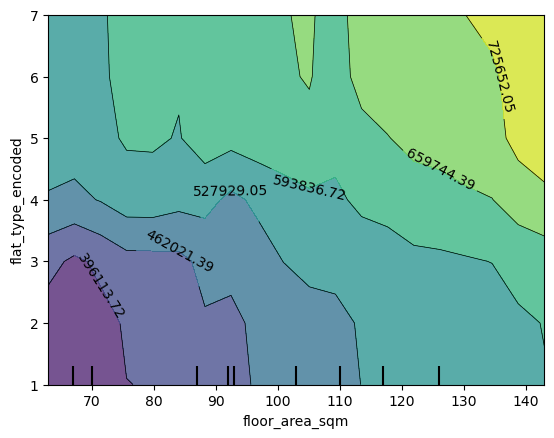

In [ ]:
# Plot interaction between 'size' and bedrooms

from sklearn.inspection import PartialDependenceDisplay
import matplotlib.pyplot as plt

# Create partial dependence plot
PartialDependenceDisplay.from_estimator(
    random_search_rf, X_train,
    features=[('floor_area_sqm', 'flat_type_encoded')],  # specify the two features
    grid_resolution=20
)
plt.show()

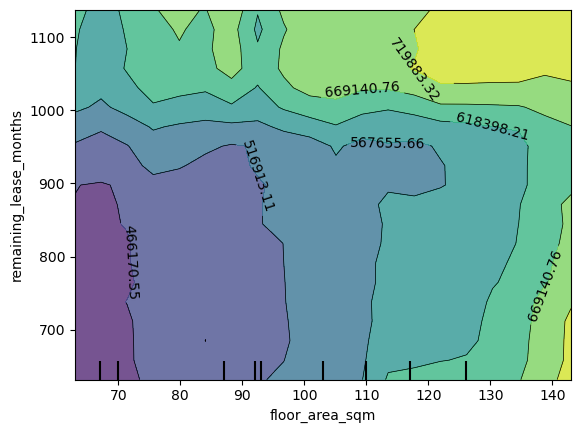

In [10]:
# Plot interaction between size and lease remaining months

from sklearn.inspection import PartialDependenceDisplay
import matplotlib.pyplot as plt

# Create partial dependence plot
PartialDependenceDisplay.from_estimator(
    random_search_rf, X_train,
    features=[('floor_area_sqm', 'remaining_lease_months')],  # specify the two features
    grid_resolution=20
)
plt.show()

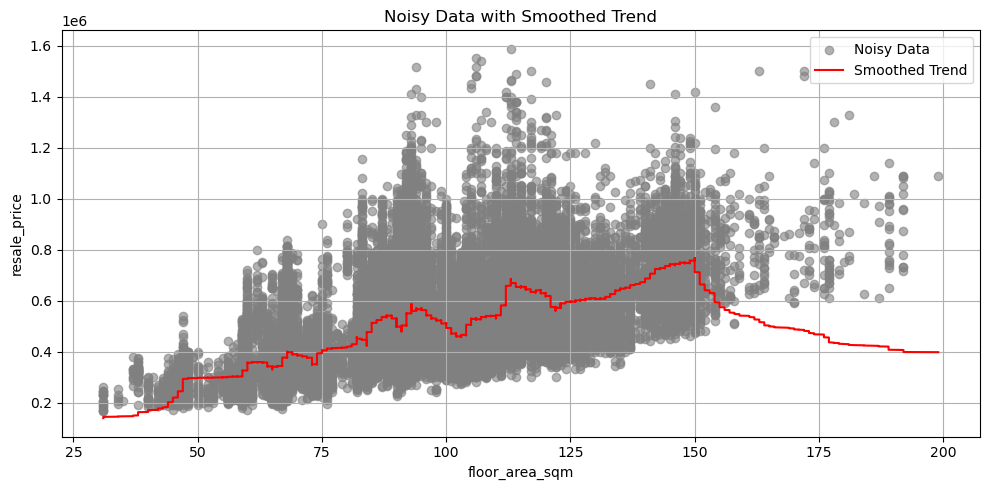

In [34]:
#Plot to show noisy data

import numpy as np
import matplotlib.pyplot as plt
from scipy.ndimage import gaussian_filter1d

# 1. Noisy data
x = test_data['floor_area_sqm']
y_noisy = test_data['resale_price']

# Sort the data by x
sorted_indices = np.argsort(x)
x_sorted = x[sorted_indices]
y_noisy_sorted = y_noisy[sorted_indices]

# # 2. Smooth version (for visual comparison)
# y_smooth = gaussian_filter1d(y_noisy, sigma=50) # Adjust sigma for smoothing

# from scipy.signal import savgol_filter
# y_smooth = savgol_filter(y_noisy, window_length=100, polyorder=1)  # Adjust parameters

# Apply smoothing to the sorted data
window_size = 1000  # Adjust the window size
y_smooth = np.convolve(y_noisy_sorted, np.ones(window_size)/window_size, mode='same')

# Plot the smoothed trend
plt.figure(figsize=(10, 5))
plt.scatter(x, y_noisy, label='Noisy Data', alpha=0.6, color='gray')
plt.plot(x_sorted, y_smooth, label='Smoothed Trend', color='red')
plt.title('Noisy Data with Smoothed Trend')
plt.xlabel('floor_area_sqm')
plt.ylabel('resale_price')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [ ]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np

# Make predictions on the test set
best_rf_model = random_search_rf.best_estimator_
rf_predictions = best_rf_model.predict(X_test)

# Calculate evaluation metrics
test_data['rf_predicted_price'] = rf_predictions
rf_mae = mean_absolute_error(y_test, rf_predictions)
rf_rmse = np.sqrt(mean_squared_error(y_test, rf_predictions))
rf_r2 = r2_score(y_test, rf_predictions) 

print("\nEvaluation Metrics for Random Forest Regression:")
print("Mean Absolute Error (MAE):", rf_mae)
print("Root Mean Squared Error (RMSE):", rf_rmse)
print("R² Score:", rf_r2) 



Evaluation Metrics for Random Forest Regression:
Mean Absolute Error (MAE): 51300.26022249333
Root Mean Squared Error (RMSE): 75949.49165780985
R² Score: 0.8222524633081242
